In [1]:
include("../../src/WaterLily.jl")
WaterLily = Main.WaterLily;
using Plots; gr()
using StaticArrays
using JLD
using Images
using FFTW

In [2]:
inside(a::AbstractArray) = CartesianIndices(map(ax->first(ax)+1:last(ax)-1,axes(a)))
@inline CI(a...) = CartesianIndex(a...)
"""
    δ(i,N::Int)
    δ(i,I::CartesianIndex{N}) where {N}

Return a CartesianIndex of dimension `N` which is one at index `i` and zero elsewhere.
"""
δ(i,::Val{N}) where N = CI(ntuple(j -> j==i ? 1 : 0, N))
δ(i,I::CartesianIndex{N}) where N = δ(i, Val{N}())

δ (generic function with 2 methods)

In [3]:
function InterpolOmega(xOrig,omega)
    x = xOrig .+ 2.0
    floorx = floor.(x)
    I = CartesianIndex(Int.(floorx)...)
    residual = x.-floorx
    N = length(I)
    s = 0.0
    for i ∈ N
        s += omega[I]*(1-residual[i]) + omega[I+δ(i,I)]*residual[i]
    end
    return s/N
end

InterpolOmega (generic function with 1 method)

In [4]:
function flood(f::Array;shift=(0.,0.),cfill=:RdBu_11,clims=(),levels=10,kv...)
    if length(clims)==2
        @assert clims[1]<clims[2]
        @. f=min(clims[2],max(clims[1],f))
    else
        clims = (minimum(f),maximum(f))
    end
    Plots.contourf(axes(f,1).+shift[1],axes(f,2).+shift[2],f',
        linewidth=0, levels=levels, color=cfill, clims = clims, 
        aspect_ratio=:equal; kv...)
end

addbody(x,y;c=:black) = Plots.plot!(Shape(x,y), c=c, legend=false)
function body_plot!(sim;levels=[0],lines=:black,R=inside(sim.flow.p))
    WaterLily.measure_sdf!(sim.flow.σ,sim.body,WaterLily.time(sim))
    contour!(sim.flow.σ[R]';levels,lines)
end

function sim_gif!(sim;duration=1,step=0.1,verbose=true,R=inside(sim.flow.p),
                    remeasure=false,plotbody=false,kv...)
    t₀ = round(WaterLily.sim_time(sim))
    @time @gif for tᵢ in range(t₀,t₀+duration;step)
        WaterLily.sim_step!(sim,tᵢ;remeasure)
        for I∈inside(sim.flow.σ)
            sim.flow.σ[I] = WaterLily.curl(3,I,sim.flow.u)*sim.L/sim.U
        end
        WaterLily.BCPer!(sim.flow.σ)
        flood(sim.flow.σ[R]; kv...)
        plotbody && body_plot!(sim)
        verbose && println("tU/L=",round(tᵢ,digits=4),
            ", Δt=",round(sim.flow.Δt[end],digits=3))
    end
end

sim_gif! (generic function with 1 method)

In [5]:
function KH(; pow=6, Re=1e5, T=Float32, mem=Array)
    # Define vortex size, velocity, viscosity
    L = 2^pow; U = 1; ν = U*L/Re
    σ = 30; ϵ = 0.05
    # Taylor-Green-Vortex initial velocity field
    function uλ(i,xyz)
        x,y = @. (xyz-1.5)/L                # scaled coordinates
        (i==1 && y<=0.5) && return U*tanh(σ*(y-0.25))
        (i==1 && y> 0.5) && return U*tanh(σ*(0.75-y))
        i==2 && return ϵ*U*sin(2pi*x)
        return 0.                              # u_z
    end
    # Initialize simulation
    return WaterLily.Simulation((L, L), (0, 0), L; U=U, uλ=uλ, ν=ν, T=T, mem=mem,perdir=(1,2))
end

KH (generic function with 1 method)

In [6]:
pow = 9

9

In [7]:
sim = KH(; pow=pow,Re=1e4)

Main.WaterLily.Simulation(1, 512, 1, Main.WaterLily.Flow{2, Float32, Matrix{Float32}, Array{Float32, 3}, Array{Float32, 4}}([-0.99999934 -0.99999934 … -0.99999934 -0.99999934; -0.99999934 -0.99999934 … -0.99999934 -0.99999934; … ; -0.99999934 -0.99999934 … -0.99999934 -0.99999934; -0.99999934 -0.99999934 … -0.99999934 -0.99999934;;; -0.00030679425 -0.00030679425 … -0.00030679425 -0.00030679425; 0.00030679425 0.00030679425 … 0.00030679425 0.00030679425; … ; -0.00030679425 -0.00030679425 … -0.00030679425 -0.00030679425; 0.00030679425 0.00030679425 … 0.00030679425 0.00030679425], [-0.99999934 -0.99999934 … -0.99999934 -0.99999934; -0.99999934 -0.99999934 … -0.99999934 -0.99999934; … ; -0.99999934 -0.99999934 … -0.99999934 -0.99999934; -0.99999934 -0.99999934 … -0.99999934 -0.99999934;;; -0.00030679425 -0.00030679425 … -0.00030679425 -0.00030679425; 0.00030679425 0.00030679425 … 0.00030679425 0.00030679425; … ; -0.00030679425 -0.00030679425 … -0.00030679425 -0.00030679425; 0.00030679425 0.

┌ Info: Saved animation to /tmp/jl_JcFaPu3618.gif
└ @ Plots /home/tyhuang/.julia/packages/Plots/3BCH5/src/animation.jl:156


943.372875 seconds (189.05 M allocations: 222.571 GiB, 1.05% gc time, 1.23% compilation time: 35% of which was recompilation)


Plots.AnimatedGif("/tmp/jl_JcFaPu3618.gif")
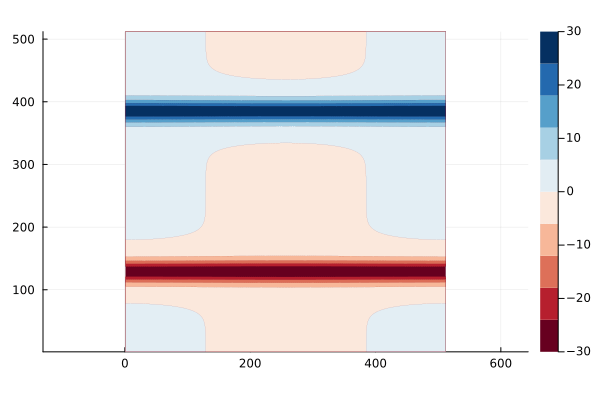

In [8]:
sim_gif!(sim,duration=1.2, step=0.1,clims=(-30,30),plotbody=false,verbose=false,levels=9)

In [9]:
for I∈inside(sim.flow.σ)
    sim.flow.σ[I] = WaterLily.curl(3,I,sim.flow.u)*sim.L/sim.U
end
WaterLily.BCPer!(sim.flow.σ)
ω = sim.flow.σ;

In [10]:
img = load("KHTestImage.png")[end:-1:1,:];
sz = size(img)

(1664, 1664)

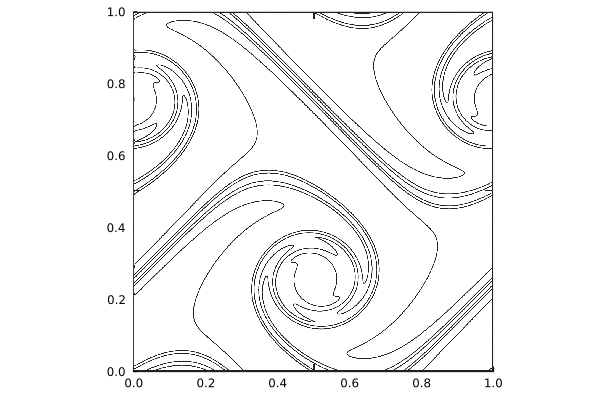

In [11]:
x, y = LinRange(0, 1, sz[1]), LinRange(0, 1, sz[2])
plot(x, y, img, xlim=(0,1), ylim=(0,1),yflip=false)


In [12]:
savefig("KHCFDVortContour_background.png")

"/home/tyhuang/Documents/Github/WaterLily.jl/test/TYTest/KHCFDVortContour_background.png"

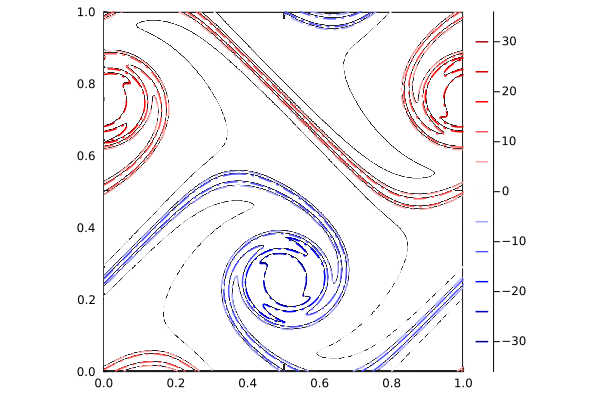

In [13]:
contour!((axes(ω,1))/2^pow, (axes(ω,2))/2^pow, ω', linewidth=1.5, linestyle=:dashdot, color=:seismic, levels=11, clims = (-36,36), aspect_ratio=:equal, xlim=(0,1), ylim=(0,1), background=nothing);
plot!()


In [14]:
savefig("KHCFDVortContour.png")

"/home/tyhuang/Documents/Github/WaterLily.jl/test/TYTest/KHCFDVortContour.png"

In [15]:
ω̂ = fft(ω[2:2^pow+1,2:2^pow+1])/2^(2pow);
# sum(abs2.(ω̂))/sum(abs2.(ω[2:257,2:257]))/256/256;
lx = ly = fftfreq(2^pow,2^pow);
maximum(ly)

255.0

In [16]:
maxK = Int(round(maximum(sqrt.(lx.^2 .+ ly.^2))))

362

In [17]:
vortK = zeros(maxK)
sumK = zeros(maxK)
sumKx = zeros(maxK)
sumKy = zeros(maxK)
for i∈1:2^pow, j∈1:2^pow
    l = sqrt(lx[i]^2 + ly[j]^2)
    (l<0.5) && continue
    vortK[Int(round(l))] += abs2(ω̂[i,j])
    sumKx[Int(round(l))] += lx[i]
    sumKy[Int(round(l))] += ly[j]
    sumK[Int(round(l))] += l
end
VortSpec = vortK./(sumKx.^2+sumKy.^2).^0.5;
VortSpec = vortK./sumK;

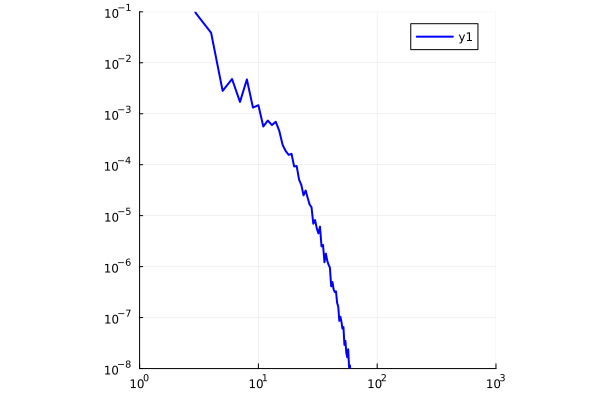

In [18]:
plot(1:maxK,VortSpec, xscale=:log10,yscale=:log10,xlim=(1,1000),ylim=(1e-8,1e-1),aspect_ratio=1e4, background=nothing,color=:blue, linewidth=2)

In [19]:
savefig("KHCFDSpectrum.png")

"/home/tyhuang/Documents/Github/WaterLily.jl/test/TYTest/KHCFDSpectrum.png"